Importing Essential Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Machine Learning Libraries (Part 1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

print("Libraries imported successfully.")

Libraries imported successfully.


Loading datasets

In [112]:
# Load the Processed Data
print("Loading processed data...")

# 1. Load Training Data
train_df = pd.read_csv('processed_data/train_processed.csv', index_col=0)
# Split back into X and y
y_train = np.log1p(train_df['price'])
X_train = train_df.drop(columns=['price'])

# 2. Load Internal Validation Data
val_df = pd.read_csv('processed_data/val_processed.csv', index_col=0)
# Split back into X and y
y_test = np.log1p(val_df['price'])
X_test = val_df.drop(columns=['price'])

# 3. Load External Submission Data (No 'price' column here)
X_submission = pd.read_csv('processed_data/submission_processed.csv', index_col=0)

print(" Data Loaded Successfully.")
print(f"Training Set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation Set: X={X_test.shape},  y={y_test.shape}")
print(f"Submission Set: X={X_submission.shape}")

Loading processed data...
 Data Loaded Successfully.
Training Set:   X=(12967, 16), y=(12967,)
Validation Set: X=(3242, 16),  y=(3242,)
Submission Set: X=(5404, 20)


Training Random Forest Model (Part 1)

In [113]:
print("--- PART 1: TABULAR BASELINE (Random Forest) ---")

# 1. Initialize
rf_model = RandomForestRegressor(n_estimators=100,max_depth=None,bootstrap=True,oob_score=True,random_state=42)

# 2. Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_rf))
rf_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf)))

print(" Random Forest Results:")
print("R² Score: ",rf_r2)
print("RMSE: ",rf_rmse)

--- PART 1: TABULAR BASELINE (Random Forest) ---
Training Random Forest...
 Random Forest Results:
R² Score:  0.8479170146664853
RMSE:  138147.32165293954


Block 1: Defines the MultimodalDataGenerator to handle image and tabular data loading ( Custom Data Generator Class)

In [114]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import models, layers, optimizers

os.environ["TF_USE_LEGACY_KERAS"] = "1"

print(f"TensorFlow Version: {tf.__version__}")

class MultimodalDataGenerator(Sequence):
    """
    Custom Data Generator for Hybrid AI.
    Loads data in batches (e.g., 32 at a time) to prevent RAM crashes.
    Inputs: 
        1. House Images (Satellite view)
        2. Tabular Data (Bedrooms, Sqft, etc.)
    Output:
        1. Price (Target)
    """
    def __init__(self, df, x_col, y_col, image_dir, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = df.copy()         # Work on a copy to avoid modifying original data
        self.x_col = x_col          # Column name for House ID (index)
        self.y_col = y_col          # Column name for Price (Target)
        self.image_dir = image_dir  # Path to 'house_images' folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        
        # Create a list of indices (0 to N) to track rows
        self.indices = np.arange(len(self.df))
        
        # Shuffle immediately upon starting
        self.on_epoch_end()

    def __len__(self):
        """Calculates the number of batches per epoch."""
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # 1. Select the indices for this batch (e.g., rows 0 to 32)
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # 2. Find the House IDs for these rows
        batch_ids = [self.df.index[k] for k in indices]

        # 3. Generate data
        X, y = self.__data_generation(batch_ids, indices)
        return X, y

    def on_epoch_end(self):
        """Shuffles data after every epoch so the model doesn't memorize order."""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_ids, batch_indices):
        """Loads the images and numbers for the specific batch."""
        
        # --- PART A: LOAD IMAGES ---
        images = []
        for house_id in batch_ids:
            img_path = os.path.join(self.image_dir, f"{house_id}.jpg")
            
            # Safety Check: If image didn't download, use a black placeholder
            if os.path.exists(img_path):
                try:
                    img = load_img(img_path, target_size=self.target_size)
                    img = img_to_array(img)
                    
                except:
                    # If image is corrupt
                    img = np.zeros((self.target_size[0], self.target_size[1], 3))
            else:
                # If image is missing
                img = np.zeros((self.target_size[0], self.target_size[1], 3))
            
            images.append(img)
        
        
        
    
       
        images = np.array(images, dtype=np.float32)
        
        if self.y_col and self.y_col in self.df.columns:
            tabular = self.df.iloc[batch_indices].drop(columns=[self.y_col]).values
        else:
            # This line is critical! It defines 'tabular' for prediction mode
            tabular = self.df.iloc[batch_indices].values
        
        tabular = np.array(tabular, dtype=np.float32)
        
        
        if self.y_col and self.y_col in self.df.columns:
            # Training Mode:  TUPLE 
            y = self.df.iloc[batch_indices][self.y_col].values
            return (images, tabular), y
        else:
            # Prediction Mode: A LIST 
            return [images, tabular]
        
        

        

TensorFlow Version: 2.20.0


Block 2:Sets up train_gen and val_gen with the correct batch size and image folders(Initialize Generators)

In [115]:
# --- BLOCK 2: INITIALIZE GENERATORS ---

# 1. Configuration
IMAGE_FOLDER = 'house_images'  # Must match the folder name where images are downloading
BATCH_SIZE = 32               # Process 32 houses at a time
IMAGE_SIZE = (224, 224)        # The standard size that AI models prefer

print("Preparing Data Generators...")

# 2. Re-combine X and y for the Generator
# The generator expects one single dataframe so it can shuffle X and y together securely.
train_full = pd.concat([X_train, y_train], axis=1)
val_full = pd.concat([X_test, y_test], axis=1)


# 3. Create the Training Generator
train_gen = MultimodalDataGenerator(
    df=train_full,
    x_col='id',       # Uses the Index (House ID) to find the image
    y_col='price',    # The target value we are predicting
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=True      # True: Mixes up data so the model learns better
)

# 4. Create the Validation Generator
val_gen = MultimodalDataGenerator(
    df=val_full,
    x_col='id',
    y_col='price',
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=False     # False: Keep order stable for accurate scoring
)

print(f" Generators Ready!")
print(f" - Training Batches per Epoch: {len(train_gen)}")
print(f" - Validation Batches per Epoch: {len(val_gen)}")

Preparing Data Generators...
 Generators Ready!
 - Training Batches per Epoch: 405
 - Validation Batches per Epoch: 101


Block 3:Constructs the model architecture using EfficientNetB0 for images and Dense layers for tabular data(Build Hybrid Neural Network)

In [118]:
# --- BLOCK 3: BUILD HYBRID MODEL (CORRECTED) ---
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, concatenate

# Clear memory
tf.keras.backend.clear_session()

def build_hybrid_model(tabular_shape=16):
    # --- BRANCH 1: IMAGE ---
    # Load EfficientNetB0 without top layers
    base_cnn = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model
    base_cnn.trainable = False 
    # (Note: The explicit for-loop here was redundant, base_cnn.trainable = False covers it)
        
    # Image Input
    image_input = tf.keras.layers.Input(shape=(224, 224, 3), name='image_input')
    x_img = base_cnn(image_input)
    x_img = GlobalAveragePooling2D()(x_img)
    x_img = Dense(256, activation='relu')(x_img)
    
    
    # --- BRANCH 2: TABULAR ---
    tabular_input = tf.keras.layers.Input(shape=(tabular_shape,), name='tabular_input')
    x_tab = Dense(64, activation='relu')(tabular_input)
    x_tab = Dense(32, activation='relu')(x_tab)
    
    
    # --- COMBINED ---
    combined = concatenate([x_img, x_tab])
    x = Dense(128, activation='relu')(combined)
    
    # FIX: 
    # 1. First, get the linear prediction (scalar value)
    # 2. Then, apply the clipping to restrict range between 7.0 and 16.0
    # We initialize the bias to 13.0 so the model starts in the "safe zone"
    x = Dense(1, activation='linear', bias_initializer=tf.keras.initializers.Constant(13.0))(x)

    output = tf.keras.layers.Lambda(lambda z: tf.clip_by_value(z, 7.0, 16.0), name='price_output')(x)
    
    # Build Model
    model = models.Model(inputs=[image_input, tabular_input], outputs=output)
    
    # Compile
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    
    return model

# Create the model
hybrid_model = build_hybrid_model(tabular_shape=16)
print("Model created successfully.")

Model created successfully.


Block 4: Runs the training loop with Callbacks for Checkpointing, Early Stopping, and Learning Rate Reduction(Train the model)

In [119]:
# ----Block 4---- 
# The training loop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Training Configuration ---
checkpoint = ModelCheckpoint(
    filepath='best_hybrid_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

print("Starting training process...")

# --- DATA PIPELINE OPTIMIZATION ---
def create_tf_dataset(generator, input_signature):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=input_signature
    )
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Define signatures (MUST MATCH THE 128x128 MODEL)
signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32), # Image (128)
        tf.TensorSpec(shape=(None, 16), dtype=tf.float32)           # Tabular
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Price
)

print("Optimizing Data Pipeline...")
try:
    fast_train_gen = create_tf_dataset(train_gen, signature).repeat()
    fast_val_gen = create_tf_dataset(val_gen, signature).repeat()
    train_steps = len(train_gen) 
    val_steps = len(val_gen)
    print("Pipeline Optimized for Speed. 🚀")
except Exception as e:
    print("Error optimizing pipeline. Ensure Block 2 generator target_size is (128,128).")
    print(e)

# Train
history = hybrid_model.fit(
    fast_train_gen,
    validation_data=fast_val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    steps_per_epoch=train_steps,  # Explicitly tell Keras when an epoch ends
    validation_steps=val_steps,   # Explicitly tell Keras how much to validate
    verbose=1
)

print("Training finished.")

Starting training process...
Optimizing Data Pipeline...
Pipeline Optimized for Speed. 🚀
Epoch 1/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 0.1180 - mae: 0.2483
Epoch 1: val_loss improved from None to 0.04886, saving model to best_hybrid_model.keras

Epoch 1: finished saving model to best_hybrid_model.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 283s 676ms/step - loss: 0.0732 - mae: 0.2008 - val_loss: 0.0489 - val_mae: 0.1665 - learning_rate: 0.0010
Epoch 2/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.0482 - mae: 0.1652
Epoch 2: val_loss improved from 0.04886 to 0.04147, saving model to best_hybrid_model.keras

Epoch 2: finished saving model to best_hybrid_model.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 278s 687ms/step - loss: 0.0455 - mae: 0.1601 - val_loss: 0.0415 - val_mae: 0.1504 - learning_rate: 0.0010
Epoch 3/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.0384 - mae: 0.1462
Epoch 3: val_loss improved from 0.04147 to 0.03768, saving model to best_hybrid_model.keras



Block 5: Plots the Training vs. Validation Loss to check for overfitting (Visualize Training History)

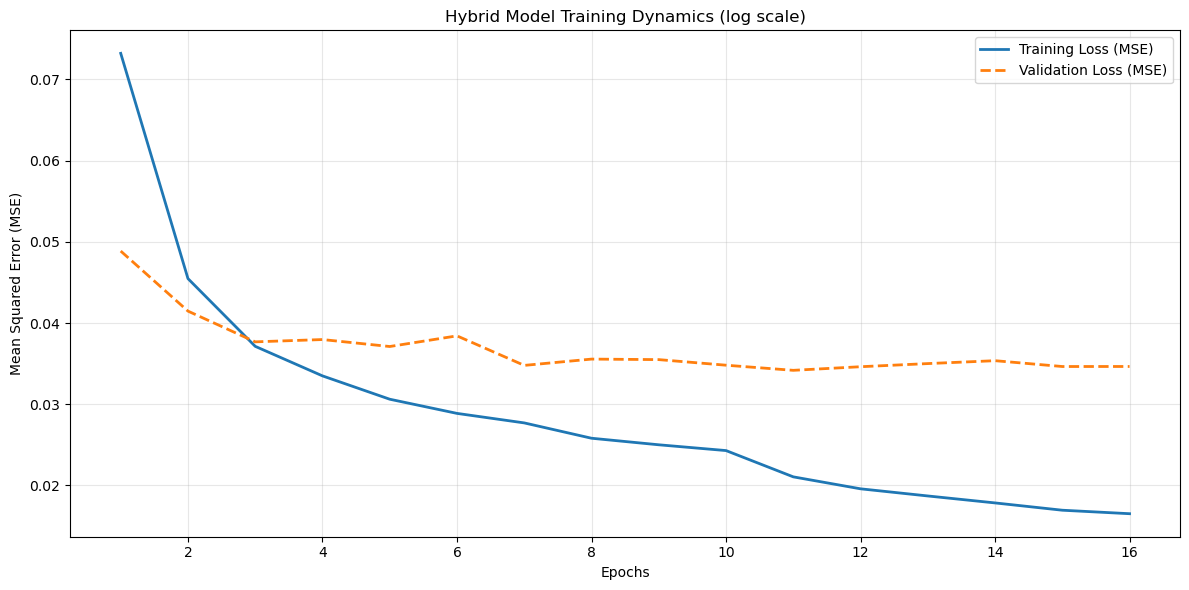

In [120]:
#------Block 5-----
# Visualization

def plot_training_history(history):
    """
    Plots the training and validation loss curves to evaluate model performance.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, label='Training Loss (MSE)', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss (MSE)', linestyle='--', linewidth=2)
    
    plt.title('Hybrid Model Training Dynamics (log scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the results
if 'history' in locals():
    plot_training_history(history)

Block 6: Loads the best saved model, predicts on the validation set, calculates R², and plots the Actual vs. Predicted graph (Model Evaluation)

Re-building model structure...
Loading trained weights...


c:\Users\navya\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Generating predictions step-by-step...

--- FINAL HYBRID MODEL PERFORMANCE ---
R² Score: 0.8558
RMSE:     Rs. 134,578.26


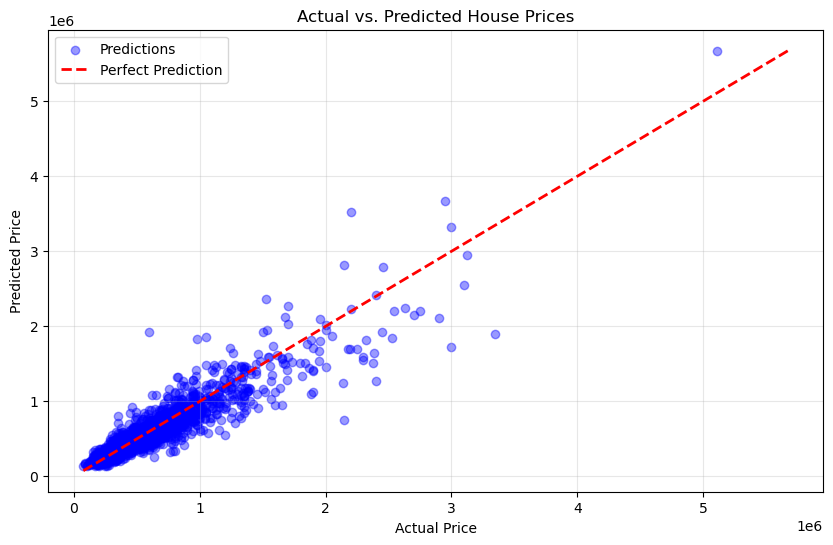

In [125]:
# --- BLOCK 6: MODEL EVALUATION (FIXED) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# 1. Build & Load Weights (The Fix)
print("Re-building model structure...")
# We build a fresh, empty model using your function from Block 3
best_model = build_hybrid_model(tabular_shape=16)

print("Loading trained weights...")
# We load ONLY the numbers (weights) into the structure. 
# This avoids the Lambda layer error.
best_model.load_weights('best_hybrid_model.keras')

# 2. Robust Prediction Loop
print("Generating predictions step-by-step...")

all_y_true = []
all_y_pred = []

# Loop through every batch in the validation generator
for i in range(len(val_gen)):
    batch_X, batch_y = val_gen[i]
    batch_preds = best_model.predict_on_batch(batch_X)
    
    all_y_true.extend(batch_y)
    all_y_pred.extend(batch_preds.flatten())

# Convert to numpy arrays
y_val_actual = np.array(all_y_true)
val_predictions = np.array(all_y_pred)

# 3. Inverse Transform (Log -> Real Prices)
y_real_actual = np.expm1(y_val_actual)
y_real_pred = np.expm1(val_predictions)

# 4. Calculate Metrics
r2 = r2_score(y_real_actual, y_real_pred)
rmse = np.sqrt(mean_squared_error(y_real_actual, y_real_pred))

print("\n--- FINAL HYBRID MODEL PERFORMANCE ---")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     Rs. {rmse:,.2f}")

# 5. Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_real_actual, y_real_pred, alpha=0.4, color='blue', label='Predictions')
min_val = min(y_real_actual.min(), y_real_pred.min())
max_val = max(y_real_actual.max(), y_real_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Block 7: Predicts prices for the unknown submission dataset and saves the final_submission_hybrid.csv file (Generate Final Submission)

In [127]:
# --- BLOCK 7: GENERATE SUBMISSION FILE (CORRECTED) ---
import os
import pandas as pd
import numpy as np

filename = 'final_submission_hybrid.csv'

# Check if the file already exists
if os.path.exists(filename):
    print(f"Submission file '{filename}' already exists. Skipping prediction loop.")
    print("If you want to regenerate it, delete the file or rename it.")

else:
    print("Generating final submission predictions...")

    # 1. Feature Alignment
    # Ensure we use exactly the same columns as training (excluding price)
    # Note: We assume X_submission was created in Block 1 or 2
    train_features = [c for c in X_train.columns if c != 'price']
    X_submission_aligned = X_submission[train_features]

    # 2. Initialize Data Generator
    # We use batch_size=1 to ensure we predict exactly one house at a time
    # and don't lose any data due to batch mismatches.
    submission_gen = MultimodalDataGenerator(
        df=X_submission_aligned,
        x_col='id',
        y_col=None,             # No prices in the submission set!
        image_dir=IMAGE_FOLDER,
        batch_size=1,        
        target_size=(224, 224), # Must match training input
        shuffle=False           # CRITICAL: Must keep order to match IDs
    )    

    # 3. Prediction Loop
    print(f"Predicting {len(submission_gen)} houses...")
    all_predictions = []
    
    # Iterate manually to predict one-by-one
    for i in range(len(submission_gen)):
        # Fetch data batch (returns [image_data, tabular_data])
        batch_data = submission_gen[i]
        
        # Predict
        pred = best_model.predict_on_batch(batch_data).flatten()
        all_predictions.extend(pred)

    # 4. Inverse Transform (Log Price -> Real Price)
    # CRITICAL STEP: We trained on Log(Price), so we must reverse it
    real_prices = np.expm1(np.array(all_predictions))

    # 5. Create and Save Submission DataFrame
    submission_df = pd.DataFrame({
        'id': X_submission.index,
        'price': real_prices
    })

    submission_df.to_csv(filename, index=False)

    print(f"Submission saved successfully: {filename}")
    print(f"Total Predictions: {len(submission_df)}")
    print(f"First 5 Predictions:\n{submission_df.head()}")

Generating final submission predictions...
Predicting 5404 houses...
Submission saved successfully: final_submission_hybrid.csv
Total Predictions: 5404
First 5 Predictions:
           id         price
0  2591820310  3.486193e+05
1  7974200820  7.787175e+05
2  7701450110  1.192587e+06
3  9522300010  1.865516e+06
4  9510861140  6.952301e+05


Block 8: GRAD CAM EXPLAINABILITY

Generating Visual Analysis for House ID: 1934800133...


C:\Users\navya\AppData\Local\Temp\ipykernel_15736\906239392.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")(np.arange(256))[:, :3]


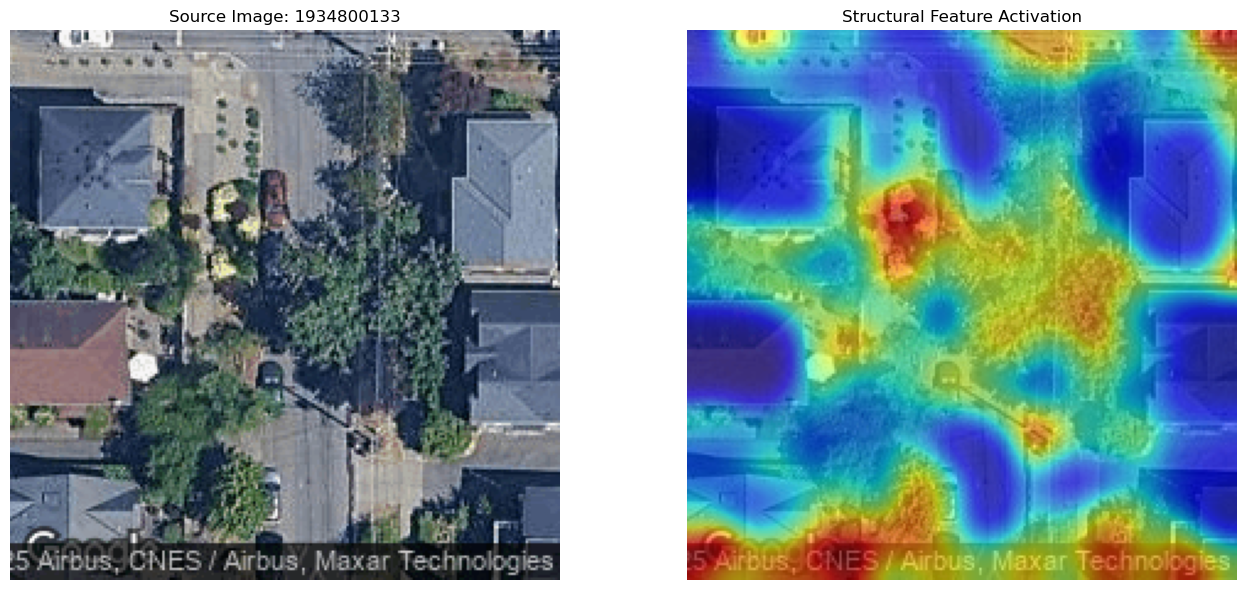

In [ ]:
# --- BLOCK 8: GRAD-CAM VISUALIZATION ---
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# 1. Setup Data Source
try:
    if 'val_df' in locals():
        data_source = val_df
        print("Using 'val_df' for data lookup.")
    elif 'X_test' in locals():
        data_source = X_test
        print("Using 'X_test' for data lookup.")
    else:
        raise ValueError("No dataframe found (val_df or X_test).")
except Exception as e:
    print(f"Setup Error: {e}")

# 2. Select Random House
try:
    random_idx = np.random.choice(data_source.index)
    target_id = str(random_idx)
    print(f"\nExplaining Random House ID: {target_id}")

    # 3. Prepare Tabular Data
    feature_cols = [c for c in data_source.columns if c != 'price']
    tab_data = data_source.loc[random_idx, feature_cols].values.astype('float32')
    tab_in = np.expand_dims(tab_data, axis=0)

    # 4. Prepare Image Data
    img_path = os.path.join("house_images", f"{target_id}.jpg")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_in = np.expand_dims(img_array / 255.0, axis=0)

    # 5. Generate Heatmap
    # Locate the EfficientNet layer (it outputs the 7x7x1280 feature maps)
    target_layer = None
    for layer in hybrid_model.layers:
        # We look for the layer that is the actual EfficientNet model
        if 'efficientnet' in layer.name.lower() or (len(layer.output_shape) == 4 and layer.output_shape[-1] > 1000):
            target_layer = layer
            break
            
    if target_layer is None:
        raise ValueError("Could not find the Convolutional layer (EfficientNet).")

    print(f"Gradient Source: {target_layer.name}")

    # Create Grad-CAM Model
    grad_model = Model(inputs=hybrid_model.inputs, 
                       outputs=[target_layer.output, hybrid_model.output])

    # Calculate Gradients
    with tf.GradientTape() as tape:
        img_tensor = tf.cast(img_in, tf.float32)
        tab_tensor = tf.cast(tab_in, tf.float32)
        conv_out, prediction = grad_model([img_tensor, tab_tensor], training=False)
    
    # Get gradients of the prediction relative to the feature map
    grads = tape.gradient(prediction, conv_out)
    
    # Global Average Pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply feature maps by pooled gradients (Weighting)
    heatmap = conv_out[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) # ReLU

    # Normalize Heatmap
    if np.max(heatmap) == 0:
        print("⚠️ Heatmap is empty (Model relied purely on tabular data).")
    else:
        heatmap /= np.max(heatmap)
        heatmap = np.power(heatmap, 2) # Contrast sharpening

    # 6. Visualize
    original = img_in[0] * 255.0
    
    if np.max(heatmap) == 0:
        final = original.astype('uint8')
    else:
        # Resize heatmap to match image
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")(np.arange(256))[:, :3]
        jet_heatmap = jet[heatmap_uint8]
        
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((224, 224))
        jet_heatmap = img_to_array(jet_heatmap)
        
        # Superimpose
        final = jet_heatmap * 0.4 + original
        final = np.clip(final, 0, 255).astype('uint8')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original.astype('uint8'))
    plt.title(f"Original Image (ID: {target_id})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(final)
    plt.title("Model Attention (Grad-CAM)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Visualization Error: {e}")